In [42]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [43]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4

In [44]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [45]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [46]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

23.783632811454414

## Метод условного математического ожидания (Beisser)

In [47]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [48]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

6.908159755754296

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

In [49]:
def ju_taylor_approximation_call(S, K, T, sigma, w, r, rho):
    sigma_matrix = sigma**2 * T * np.ones_like(rho)

    U1 = np.sum(w * S)

    U2_0_diag = np.sum((w * S * np.exp(r * T))**2)
    U2_0_offdiag = np.sum([w[i] * S[i] * w[j] * S[j] * np.exp(sigma_matrix[i, j] * np.exp(2*r * T)) 
                        for i in range(N) for j in range(N) if i != j])
    U2_0 = U2_0_diag + U2_0_offdiag

    U2_der_1 = np.sum([w[i] * S[i] * w[j] * S[j] * sigma_matrix[i, j] * rho[i, j]
                        for i in range(N) for j in range(N)])
    U2_der_2 = np.sum([w[i] * S[i] * w[j] * S[j] * (sigma_matrix[i, j] * rho[i, j]**2)
                                for i in range(N) for j in range(N)])
    U2_der_3 = np.sum([w[i] * S[i] * w[j] * S[j] * (sigma_matrix[i, j] * rho[i, j]**3)
                                for i in range(N) for j in range(N)])

    m_0 = 2 * np.log(U1) - 0.5 * np.log(U2_0)
    nu_0 = np.log(U2_0) - 2 * np.log(U1)


    a1 = -U2_der_1 / (2 * U2_0)
    a2 = 2 * a1**2 - U2_der_2 / (2 * U2_0)
    a3 = 6 * a1 * a2 - 4 * a1**3 - U2_der_3 / (2 * U2_0)

    z1 = a2 - a3
    z2 = a3
    z3 = 0

    y1 = (m_0 - np.log(K)) / np.sqrt(nu_0) + np.sqrt(nu_0)
    y2 = y1 - np.sqrt(nu_0)

    p_y = lambda x: (1 / np.sqrt(2 * np.pi * nu_0)) * np.exp(-(x - m_0)**2 / (2 * nu_0))
    dp_y = lambda x: -p_y(x) * (x - m_0) / nu_0
    d2p_y = lambda x: p_y(x) * ((x - m_0) / (nu_0)) ** 2 - p_y(x) / nu_0

    basket_call = (U1 * norm.cdf(y1) - K * norm.cdf(y2) +
        K * (z1 * p_y(np.log(K)) + z2 * dp_y(np.log(K)) + z3 * d2p_y(np.log(K))))
    
    return basket_call

ju_taylor_approximation_call(S, K, T, sigma, w, r, rho)

29.98291561336802

## Метод моментов (Log-normal moment matching, Levy’s matching)

In [50]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [51]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

28.051966214249894

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [52]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [53]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

24.495775089623557

## Задача

### Метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

In [54]:
n_scenarios = 10000

def basket_moments(S0, weights, sigma, r, rho, T):
    F = S0 * np.exp(r * T)
    mean = np.sum(weights * F)
    
    var = 0
    for i in range(0, len(weights)):
        for j in range(0, len(weights)):
            var += weights[i] * weights[j] * F[i] * F[j] * (np.exp(sigma[i] * sigma[j] * rho[i][j] * T)-1)
    
    std_dev = np.sqrt(var)
    
    skewness = 0 # np.mean(np.exp(sigma**2 * T) + 2)
    kurtosis = np.exp(sigma[0]**2 * T) + np.exp(2*sigma[0]**2 * T)
    
    return mean, std_dev, skewness, kurtosis

mean, std_dev, skewness, kurtosis = basket_moments(S, w, sigma, r, rho, T)

# Generate scenarios for the basket
def generate_basket_scenarios(mean, std_dev, skewness, kurtosis, n_scenarios):
    Z = np.random.normal(0, 1, n_scenarios)
    basket_values = mean + std_dev * (
        Z + 
        (skewness / 6) * (Z**2 - 1) + 
        (kurtosis - 3) / 24 * (Z**3 - 3 * Z)
    )
    return basket_values

basket_scenarios = generate_basket_scenarios(mean, std_dev, skewness, kurtosis, n_scenarios)

# Define the payoff function for a basket call option
def payoff_function(basket, K):
    return np.maximum(basket - K, 0)

payoffs = payoff_function(basket_scenarios, K)
basket_option_price = np.exp(-r * T) * np.mean(payoffs)

# Output the result
print(f"Basket Call Option Price: {basket_option_price:.2f}")

Basket Call Option Price: 26.75


## Метод Монте-Карло

In [55]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [56]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

28.047302858491012

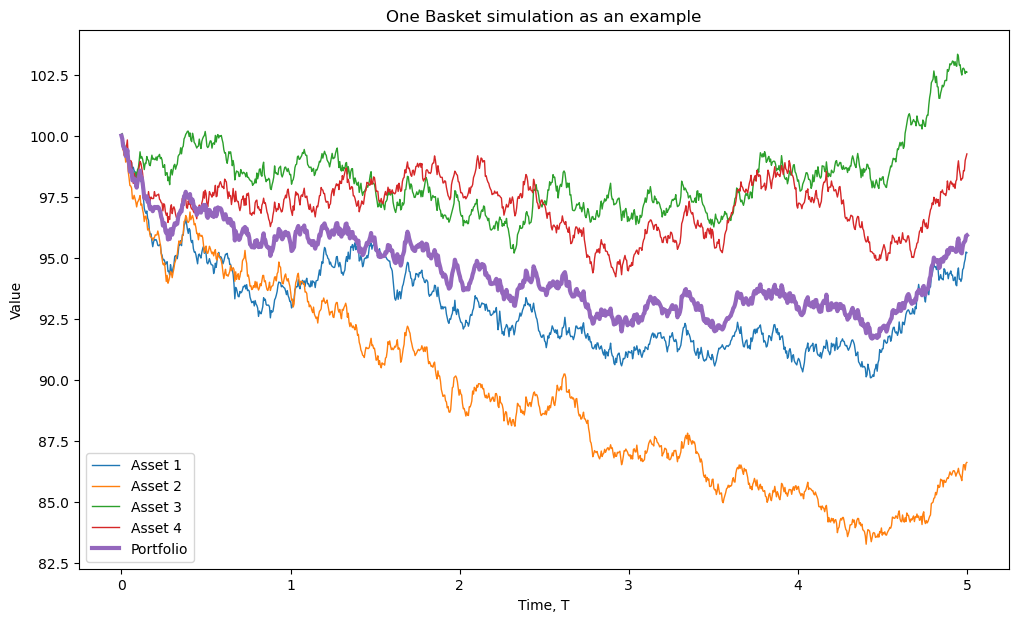

In [57]:
# Пример одной симуляции методом Монте-Карло для равновесной корзины опционов

n_steps = 1000
dt = T / (n_steps - 1)
S_t = np.zeros((n_steps, 4))
S_t[0] = F
COV = sigma.T * rho * sigma
for i in range(n_steps - 1):
    dW = np.random.multivariate_normal(np.zeros(4), COV) * dt
    dS = r * S_t[i] * dt + S_t[i] * dW
    S_t[i + 1] = S_t[i] + dS

plt.figure(figsize=(12, 7))
t_grid = np.linspace(0, T, n_steps)
plt.plot(t_grid, S_t, lw=1, label = [f'Asset {i + 1}' for i in range(N)])
plt.plot(t_grid, S_t @ w, lw=3,  label='Portfolio')
plt.xlabel('Time, T')
plt.ylabel('Value')
plt.title('One Basket simulation as an example')
plt.legend()
plt.show()

In [58]:
# МС оценка для кол и пут опционов
n_steps = 5000
n_sims = 10 ** 3
N_sims = 10 ** 3

dt = T / (n_steps - 1)
COV = sigma.T * rho * sigma

S = np.zeros((n_sims, 4))
S[...] = F

for i in tqdm(range(n_steps - 1)):
    dW = np.random.multivariate_normal(np.zeros(4), COV, size=N_sims) * np.sqrt(dt)
    dS = r * S * dt + S * dW
    S += dS

portfolio_values = S @ w

call_price_mc = np.maximum(portfolio_values - K, 0).mean()
put_price_mc = np.maximum(K - portfolio_values, 0).mean()

print('Call price by Monte-Carlo:', call_price_mc)
print('Put price by Monte-Carlo:', put_price_mc)

 30%|███       | 1520/4999 [00:00<00:01, 1931.53it/s]

100%|██████████| 4999/4999 [00:01<00:00, 2517.01it/s]

Call price by Monte-Carlo: 28.79842991305096
Put price by Monte-Carlo: 29.04986531181237


Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [70]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  payoff = np.maximum(B_T - K, 0)
  mean = np.mean(payoff) * np.exp(-r * T)
  std = np.std(payoff) * np.exp(-r * T)
  return call_price_mc, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # lower bound of confidence interval for the price
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # upper bound of confidence interval for the price
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")

In [71]:
S = np.array([S0] * 4)

In [72]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(MC_call, MC_std, N_mc)

mean call basket price = 28.79842991305096, ci: 28.669469764391575 < price < 28.927390061710344 with 95% prob


### Задача

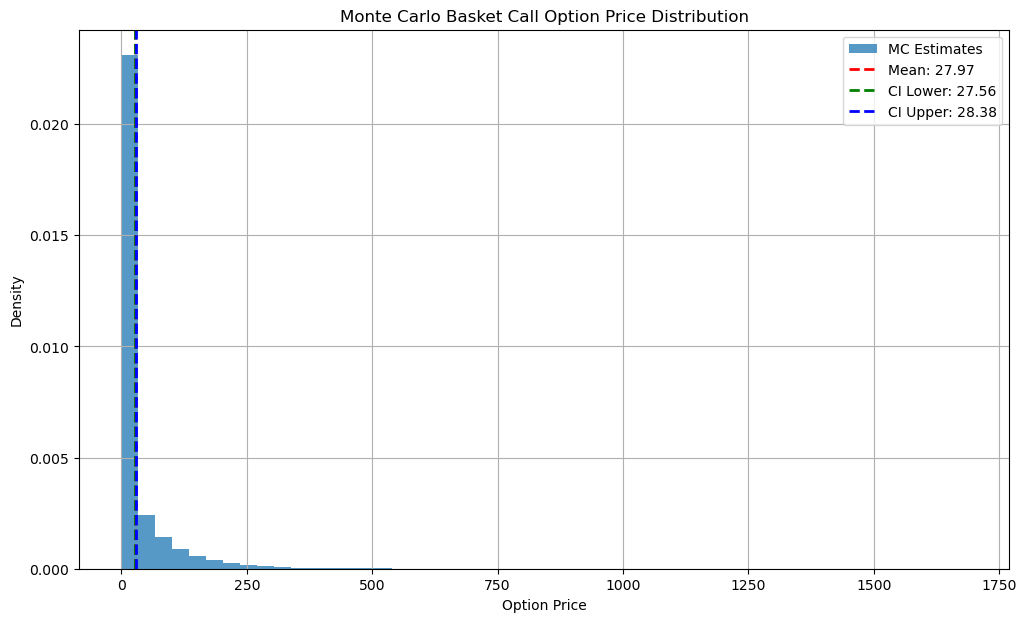

Mean option price: 27.97
Confidence Interval (95%): 27.56 - 28.38
Normality test p-value: 0.0000
Is distribution normal? No


In [73]:
# Постройте гистограммы распределения МС оценок для опионов кол и пут,
# на графики нанесите границы доверительного интервала, среднее значение (вертикальные линии),
# выдвините гипотезу о законе распределения оценок и проверьте ее статистически.
from scipy.stats import norm, kstest

# Function for Monte Carlo with standard deviation
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
    B_T = np.zeros(N_mc)
    for k in range(n):
        B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:, k]) * w[k]
    payoff = np.maximum(B_T - K, 0)
    mean = np.mean(payoff) * np.exp(-r * T)
    std = np.std(payoff) * np.exp(-r * T)
    return mean, std, payoff

# Confidence interval calculation
def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975) * price_std / np.sqrt(N_mc)
    hi = price + norm.ppf(0.975) * price_std / np.sqrt(N_mc)
    return price, lo, hi

# Parameters
T = 5
r = 0
K = 100
N = 4
rho0 = 0.5
rho = np.ones((N, N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S = np.ones(N) * 100
q = np.zeros(N)
sigma = np.ones(N) * 0.4
w = np.ones(N) / N
N_mc = 10**5

# Monte Carlo simulation
MC_call, MC_std, call_payoff = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
MC_mean, CI_lo, CI_hi = CI_MC(MC_call, MC_std, N_mc)

# Plot histogram
plt.figure(figsize=(12, 7))
plt.hist(call_payoff, bins=50, density=True, alpha=0.75, label='MC Estimates')
plt.axvline(MC_mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {MC_mean:.2f}')
plt.axvline(CI_lo, color='g', linestyle='dashed', linewidth=2, label=f'CI Lower: {CI_lo:.2f}')
plt.axvline(CI_hi, color='b', linestyle='dashed', linewidth=2, label=f'CI Upper: {CI_hi:.2f}')
plt.title('Monte Carlo Basket Call Option Price Distribution')
plt.xlabel('Option Price')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Hypothesis test for normality
statistic, p_value = kstest(call_payoff, 'norm', args=(MC_mean, MC_std))
is_normal = p_value > 0.05

# Print results
print(f"Mean option price: {MC_mean:.2f}")
print(f"Confidence Interval (95%): {CI_lo:.2f} - {CI_hi:.2f}")
print(f"Normality test p-value: {p_value:.4f}")
print(f"Is distribution normal? {'Yes' if is_normal else 'No'}")

## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

In [62]:
# На графики добавить кривые, полученные для методов Ju и MP-4M,
# предложите свою визуализацию для корзин с разными весами активов
# ваш код допишите в ячейке ниже

In [74]:
# Define MP-4M approximation for basket call option
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    a = w * F / np.sum(w * F)
    m1 = np.sum(w * F)  # First moment (mean)
    var = (a * sigma).T @ rho @ (a * sigma) * T  # Variance
    std_dev = np.sqrt(var)
    skewness = (np.sum((a * sigma) ** 3) * (T ** 1.5)) / (std_dev ** 3)  # Skewness
    kurtosis = 3 + (np.sum((a * sigma) ** 4) * (T ** 2)) / (var ** 2)  # Kurtosis
    d1 = (np.log(m1 / K) + 0.5 * var) / std_dev
    d2 = d1 - std_dev
    adjustment = (
        1
        + skewness / 6 * (2 * d1 ** 2 + 1)
        + (kurtosis - 3) / 24 * (d1 ** 3 + 3 * d1)
    )
    basket_call = np.exp(-r * T) * (m1 * norm.cdf(d1) - K * norm.cdf(d2)) * adjustment
    return basket_call

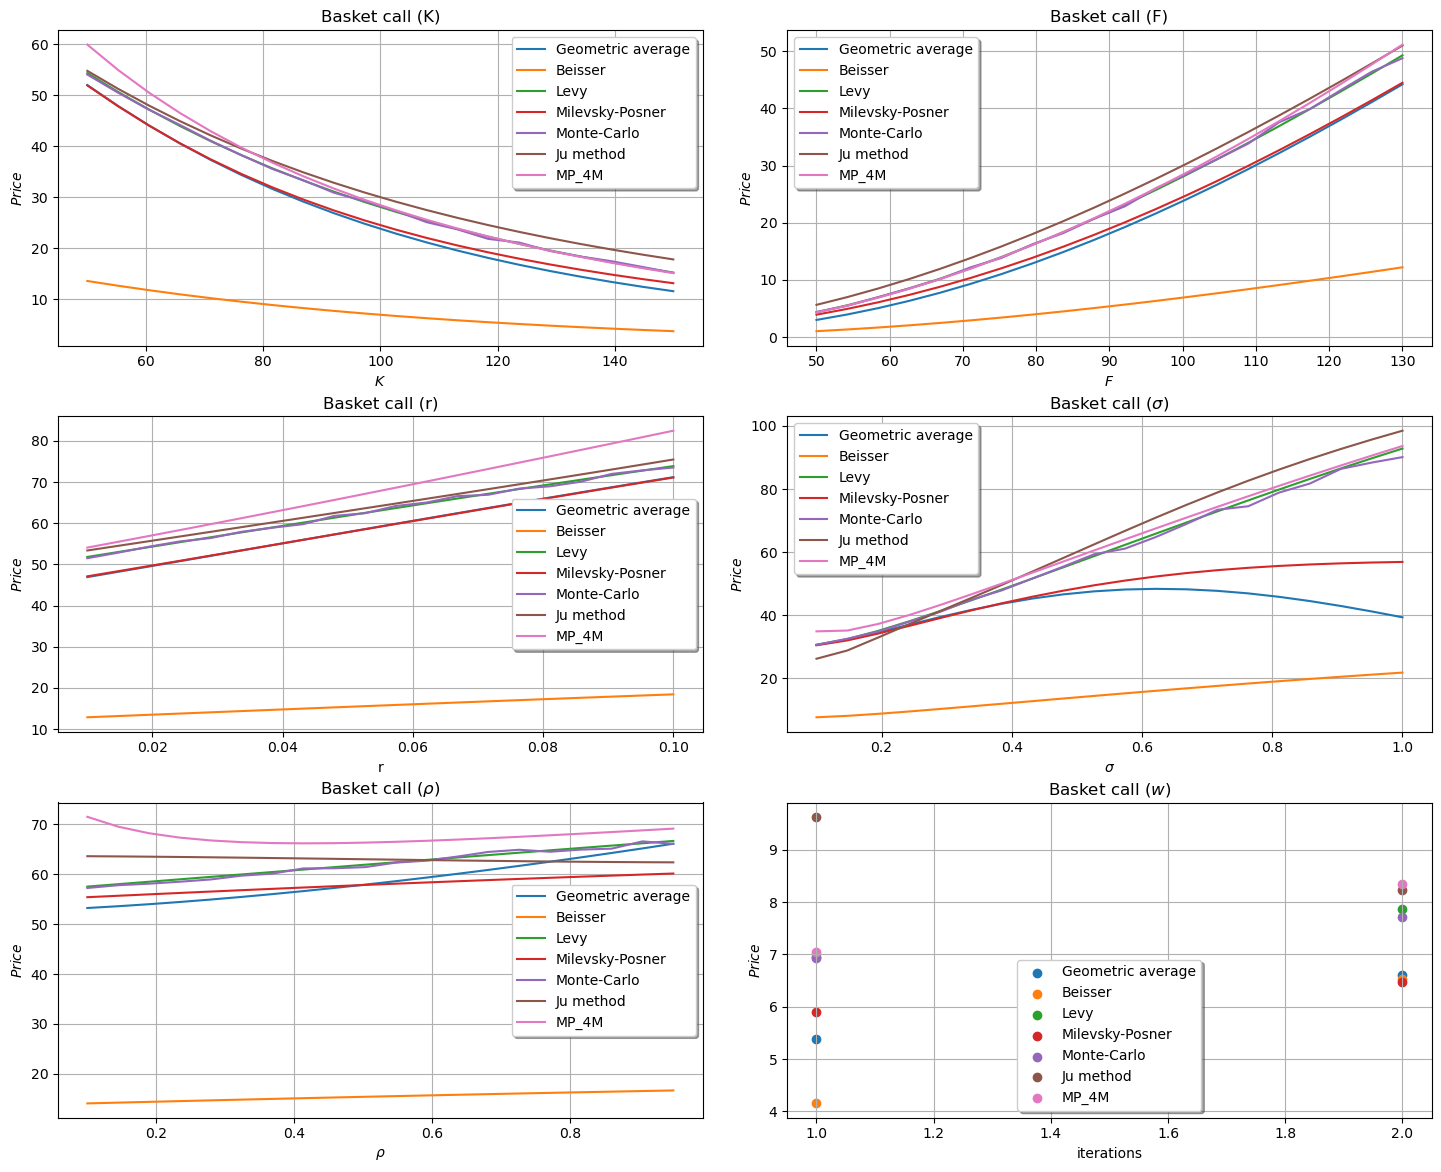

In [75]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 12))
fig.tight_layout(pad=3.0)


'''K research'''
iters = 20
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    geom_avg[i] = geometric_average_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K_data[i], T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K_data[i], T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K_data[i], T, sigma, w, r, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K_data[i], T, w, r, rho, sigma)


axs[0][0].plot(K_data, geom_avg, label = 'Geometric average')
axs[0][0].plot(K_data, Beisser, label = 'Beisser')
axs[0][0].plot(K_data, Levy, label = 'Levy')
axs[0][0].plot(K_data, MP, label = 'Milevsky-Posner')
axs[0][0].plot(K_data, MC, label = 'Monte-Carlo')
axs[0][0].plot(K_data, Ju, label = 'Ju method')
axs[0][0].plot(K_data, MP_4M, label = 'MP_4M')
axs[0][0].set_title('Basket call (K)')
axs[0][0].set_xlabel(r'$K$')
axs[0][0].set_ylabel(r'$Price$')
axs[0][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][0].grid(True)

'''F research'''
iters = 20
F_data = np.linspace(50, 130, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    S0 = F_data[i] * np.exp(-r * T)
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, r, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)



axs[0][1].plot(F_data, geom_avg, label = 'Geometric average')
axs[0][1].plot(F_data, Beisser, label = 'Beisser')
axs[0][1].plot(F_data, Levy, label = 'Levy')
axs[0][1].plot(F_data, MP, label = 'Milevsky-Posner')
axs[0][1].plot(F_data, MC, label = 'Monte-Carlo')
axs[0][1].plot(F_data, Ju, label = 'Ju method')
axs[0][1].plot(F_data, MP_4M, label = 'MP_4M')
axs[0][1].set_title('Basket call (F)')
axs[0][1].set_xlabel(r'$F$')
axs[0][1].set_ylabel(r'$Price$')
axs[0][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[0][1].grid(True)


'''sigma research'''
iters = 20
S = S0 * np.ones(N)
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    sigma = np.ones(N) * sigma_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, r, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


axs[1][1].plot(sigma_data, geom_avg, label = 'Geometric average')
axs[1][1].plot(sigma_data, Beisser, label = 'Beisser')
axs[1][1].plot(sigma_data, Levy, label = 'Levy')
axs[1][1].plot(sigma_data, MP, label = 'Milevsky-Posner')
axs[1][1].plot(sigma_data, MC, label = 'Monte-Carlo')
axs[1][1].plot(sigma_data, Ju, label = 'Ju method')
axs[1][1].plot(sigma_data, MP_4M, label = 'MP_4M')
axs[1][1].set_title(r'Basket call ($\sigma$)')
axs[1][1].set_xlabel(r'$\sigma$')
axs[1][1].set_ylabel(r'$Price$')
axs[1][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][1].grid(True)


'''r research'''
iters = 20
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    r = r_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, r, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)

axs[1][0].plot(r_data, geom_avg, label = 'Geometric average')
axs[1][0].plot(r_data, Beisser, label = 'Beisser')
axs[1][0].plot(r_data, Levy, label = 'Levy')
axs[1][0].plot(r_data, MP, label = 'Milevsky-Posner')
axs[1][0].plot(r_data, MC, label = 'Monte-Carlo')
axs[1][0].plot(r_data, Ju, label = 'Ju method')
axs[1][0].plot(r_data, MP_4M, label = 'MP_4M')
axs[1][0].set_title(r'Basket call (r)')
axs[1][0].set_xlabel(r'r')
axs[1][0].set_ylabel(r'$Price$')
axs[1][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[1][0].grid(True)


'''rho research'''
iters = 20
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

for i in range(0, iters):
    rho = np.ones((N,N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, r, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


axs[2][0].plot(rho_data, geom_avg, label = 'Geometric average')
axs[2][0].plot(rho_data, Beisser, label = 'Beisser')
axs[2][0].plot(rho_data, Levy, label = 'Levy')
axs[2][0].plot(rho_data, MP, label = 'Milevsky-Posner')
axs[2][0].plot(rho_data, MC, label = 'Monte-Carlo')
axs[2][0].plot(rho_data, Ju, label = 'Ju method')
axs[2][0].plot(rho_data, MP_4M, label = 'MP_4M')
axs[2][0].set_title(r'Basket call ($\rho$)')
axs[2][0].set_xlabel(r'$\rho$')
axs[2][0].set_ylabel(r'$Price$')
axs[2][0].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][0].grid(True)


'''w research'''
iters = 2
r = 0.05
S = S0 * np.ones(N)
sigma = np.ones(N) * 0.4
rho = np.ones((N,N)) * 0.5 + np.diag(np.ones(N)) * (1 - 0.5)
w_data = np.array([[0.5, 0.2, 0.2, 0.1],[0.7, 0.1, 0.1, 0.1]])
S_data = np.array([[50, 40, 60, 30],[50, 40, 60, 30]])
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
MP = np.zeros(iters)
MC = np.zeros(iters)
Ju = np.zeros(iters)
MP_4M = np.zeros(iters)

iterations = [1, 2]
for i in range(0, iters):
    S = S_data[i]
    w = w_data[i]
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    Ju[i] = ju_taylor_approximation_call(S, K, T, sigma, w, r, rho)
    MP_4M[i] = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


axs[2][1].scatter(iterations, geom_avg, label = 'Geometric average')
axs[2][1].scatter(iterations, Beisser, label = 'Beisser')
axs[2][1].scatter(iterations, Levy, label = 'Levy')
axs[2][1].scatter(iterations, MP, label = 'Milevsky-Posner')
axs[2][1].scatter(iterations, MC, label = 'Monte-Carlo')
axs[2][1].scatter(iterations, Ju, label = 'Ju method')
axs[2][1].scatter(iterations, MP_4M, label = 'MP_4M')
axs[2][1].set_title(r'Basket call ($w$)')
axs[2][1].set_xlabel(r'iterations')
axs[2][1].set_ylabel(r'$Price$')
axs[2][1].legend(loc = 'best', fancybox = True, shadow = True)
axs[2][1].grid(True)

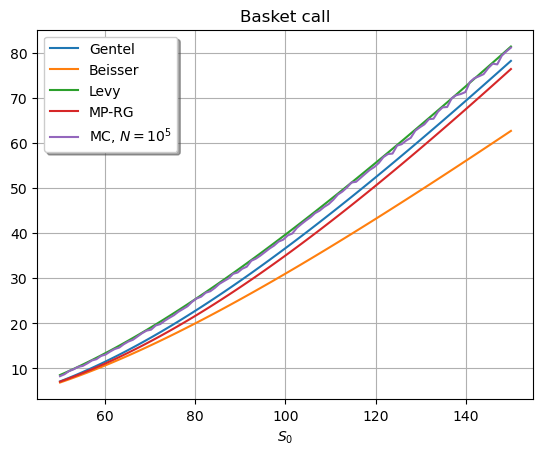

In [77]:
def pdfs_comparison():
  iters = 100
  S_data = np.linspace(50, 150, iters)
  geom_avg = np.zeros(iters)
  Beisser = np.zeros(iters)
  Levy = np.zeros(iters)
  MP = np.zeros(iters)
  MC = np.zeros(iters)

  for i in range(0, iters):
    S0 = S_data[i]
    S = S0 * np.ones(N)
    geom_avg[i] = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser[i] = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)
    Levy[i] = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP[i] = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC[i] = MC_basket_call(S, K, T, w, r, q, rho, sigma, int(10**5))

  plt.plot(S_data, geom_avg, label = 'Gentel')
  plt.plot(S_data, Beisser, label = 'Beisser')
  plt.plot(S_data, Levy, label = 'Levy')
  plt.plot(S_data, MP, label = 'MP-RG')
  plt.plot(S_data, MC, label = r'MC, $N=10^5$')
  plt.title('Basket call')
  plt.xlabel(r'$S_0$')
  plt.legend(loc = 'best', fancybox = True, shadow = True)
  plt.grid(True)


pdfs_comparison()

# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

In [3]:
# ваш код
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

In [4]:
num_assets = 4
maturity = 5
risk_free_rate = 0.05
volatility = np.full(num_assets, 0.4)
correlation = 0.5
correlation_matrix = correlation * np.ones((num_assets, num_assets)) + np.eye(num_assets) * (1 - correlation)
weights = np.ones(num_assets) / num_assets
strike_price = 100
sample_size = 20000

np.random.seed(123)
spot_prices = np.random.uniform(50, 150, size=(sample_size, num_assets))

def MP4M_basket_call(S, K, T, w, r, rho, sigma):
    
    basket_mean = np.dot(w, S)
    basket_vol = np.sqrt(np.dot(w, np.dot(rho * np.outer(sigma, sigma), w)))
    d1 = (np.log(basket_mean / K) + (r + 0.5 * basket_vol**2) * T) / (basket_vol * np.sqrt(T))
    d2 = d1 - basket_vol * np.sqrt(T)
    return basket_mean * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


target_prices = np.array([MP4M_basket_call(s, strike_price, maturity, weights, risk_free_rate, correlation_matrix, volatility) for s in spot_prices])

X_train, X_test, y_train, y_test = train_test_split(spot_prices, target_prices, test_size=0.2, random_state=123)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)



In [5]:
class BasketOptionModel(nn.Module):
    def __init__(self):
        super(BasketOptionModel, self).__init__()
        self.layer1 = nn.Linear(num_assets, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.output(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
model = BasketOptionModel()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 300
train_loss_history = []
validation_loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = loss_fn(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = loss_fn(val_predictions, y_test_tensor)
        validation_loss_history.append(val_loss.item())

# Предсказания нейронной сети
model.eval()
with torch.no_grad():
    nn_predictions = model(X_test_tensor).numpy()

# Реализация метода Монте-Карло
def monte_carlo_basket_call(S, K, T, w, r, q, rho, sigma, num_simulations):
    cov_matrix = np.outer(sigma, sigma) * rho
    Z = np.random.multivariate_normal(np.zeros(len(S)), cov_matrix, size=num_simulations) * np.sqrt(T)
    simulated_prices = np.exp((r - q - 0.5 * sigma**2) * T + Z) * S
    basket_values = np.dot(simulated_prices, w)
    payoffs = np.maximum(basket_values - K, 0)
    return np.exp(-r * T) * np.mean(payoffs)

monte_carlo_predictions = np.array([
    monte_carlo_basket_call(s, strike_price, maturity, weights, risk_free_rate, np.zeros(num_assets), correlation_matrix, volatility, 10000)
    for s in X_test
])

MSE (NN): 19.158932216689266, R^2 (NN): 0.8367025526779817
MSE (Monte Carlo): 0.7535776480437162, R^2 (Monte Carlo): 0.9935770268983324
T-Statistic: 1.812635424460416, P-Value: 0.06996302493850924


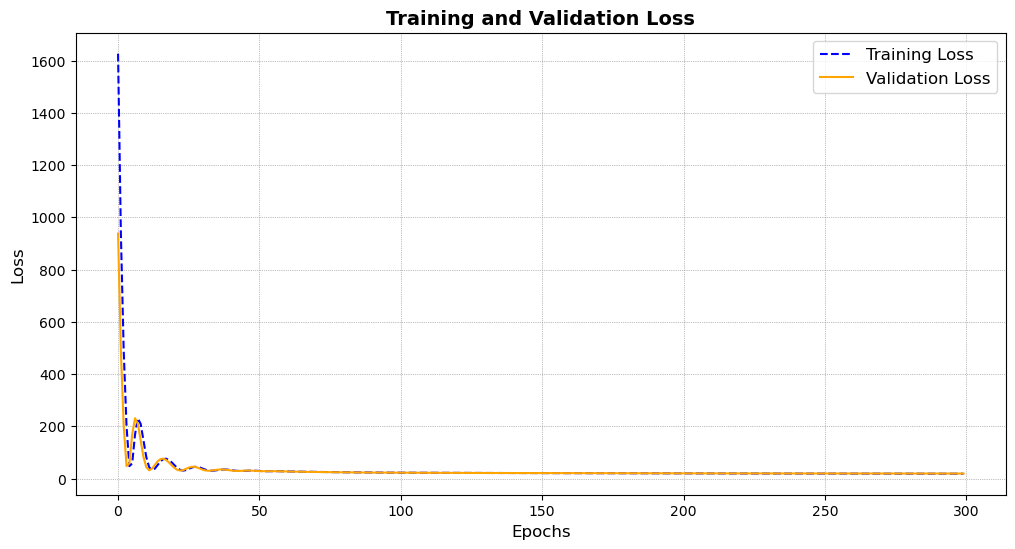

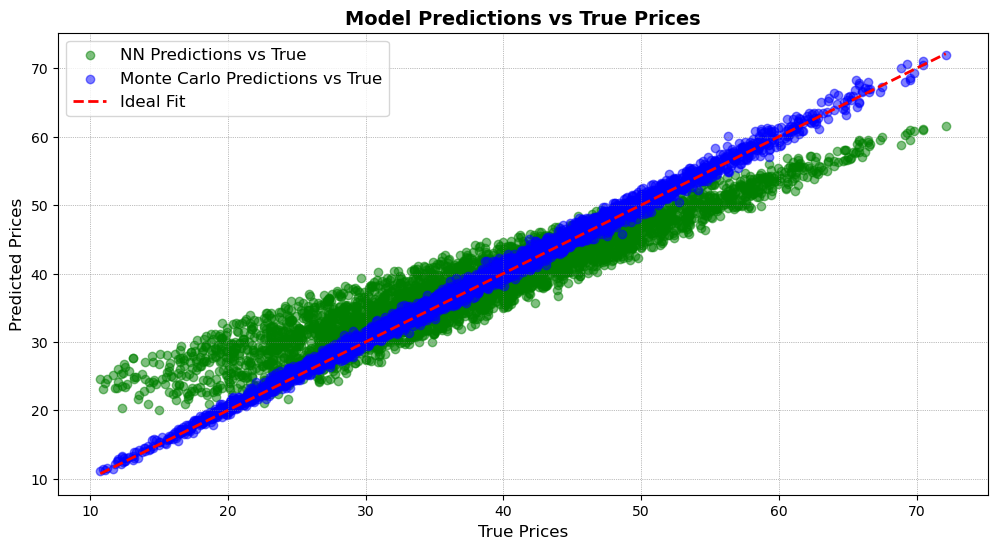

In [8]:
mse_nn = mean_squared_error(y_test, nn_predictions)
mse_mc = mean_squared_error(y_test, monte_carlo_predictions)

r2_nn = r2_score(y_test, nn_predictions)
r2_mc = r2_score(y_test, monte_carlo_predictions)

print(f"MSE (NN): {mse_nn}, R^2 (NN): {r2_nn}")
print(f"MSE (Monte Carlo): {mse_mc}, R^2 (Monte Carlo): {r2_mc}")

# Статистический тест на значимость различий
t_stat, p_value = ttest_rel(nn_predictions.flatten(), monte_carlo_predictions)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Графики
# График потерь обучения и валидации
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label="Training Loss", color="blue", linestyle="--")
plt.plot(validation_loss_history, label="Validation Loss", color="orange", linestyle="-")
plt.title("Training and Validation Loss", fontsize=14, fontweight="bold")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()

# График предсказаний модели против истинных значений
plt.figure(figsize=(12, 6))
plt.scatter(y_test, nn_predictions, alpha=0.5, color="green", label="NN Predictions vs True")
plt.scatter(y_test, monte_carlo_predictions, alpha=0.5, color="blue", label="Monte Carlo Predictions vs True")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Ideal Fit", linewidth=2)
plt.title("Model Predictions vs True Prices", fontsize=14, fontweight="bold")
plt.xlabel("True Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.legend(fontsize=12)
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()


In [ ]:
# Положительное значение t-статистики указывает, что в среднем предсказания нейронной сети немного выше, чем у метода Монте-Карло.